# Binary Classification - Cats vs. Dogs

Welcome to your Third assignment! You will train a simple neural network model to distinguish cat pictures from dog pictures. In this assignment, we'll practice such process under a binary classification context. 
- A binary classification task is to categorize an object into one of the two classes. 
- Use all pixels in an image as the features. 


## Exercises:
1. $\color{violet}{\textbf{(20\%) Data Preprocessing}}$
2. $\color{violet}{\textbf{(5\%) Logistic Regression Model}}$
3. $\color{violet}{\textbf{(5\%) Cross Entropy Loss}}$
4. $\color{violet}{\textbf{(40\%) Gradient Descent Optimization}}$
5. $\color{violet}{\textbf{(15\%) Evaluation on Test Dataset}}$
6. $\color{violet}{\textbf{(15\%) Test Model with New Image}}$


## Instructions:
- Write your code only between the $\color{green}{\textbf{\small \#\#\# START CODE HERE \#\#\#}}$ and $\color{green}{\textbf{\small \#\#\# END CODE HERE \#\#\#}}$ commented lines. $\color{red}{\textbf{Modify code out of the designated area at your own risk.}}$
- Reference answers are provided after a certain coding blocks. Be aware if your answer is different from the reference..
- **Need to install [PyTorch](https://pytorch.org/), [opencv-python](https://pypi.org/project/opencv-python/) and [pandas](https://pandas.pydata.org/).** Use the following command in your terminal.
    ```console
    pip install torch opencv-python pandas
    ```
## After this assignment you will:
- Be able to train a neural network model to do binary classification task.
    - Use sigmoid activation function.
    - Learn a new loss function: cross entropy.
    - Practice gradient descent.

## 1. Load the Data and Create a Dataset
### 1.1 Create an Annotation File
Data is not always stored in NumPy arrays. Most cases, you will have to organize and annotate the raw data stored in your hard drive. For image data, you want it to be organized as the following way.
``` console
root/dog/xxx.jpg
root/dog/xxy.jpg
root/dog/xxz.jpg

root/cat/123.jpg
root/cat/456.jpg
root/cat/789.jpg
```
To grab image information and store them in an comma-seperated values (CSV) file:
1. Visit the data directory, grab all images' paths and corresponding categories.
2. Save the paths and categories of images in an `.csv` file 

In [2]:
import sys
import os
from glob import glob
import pandas as pd

# Locate train and test directories
root_dir = "./dataset"  # locate dataset directory from this repo in the whole system
train_dir = os.path.join(root_dir, "train")
test_dir = os.path.join(root_dir, "test")
categories = ['cats', 'dogs']

# Glob training files
train_cat_files = glob(os.path.join(train_dir, categories[0], "*.jpg"))
train_dog_files = glob(os.path.join(train_dir, categories[1], "*.jpg"))
print(f"There are {len(train_cat_files)} cat images, and {len(train_dog_files)} dog images in the training dataset")
train_image_files = train_cat_files + train_dog_files
train_labels = ['cat'] * len(train_cat_files) + ['dog'] * len(train_dog_files)
train_data_dict = {'path': train_image_files, 'label': train_labels}
df_train = pd.DataFrame(train_data_dict)
# print(df_train)
df_train.to_csv('annotation_train.csv', header=False, index=False)

# Glob test files
test_cat_files = glob(os.path.join(test_dir, categories[0], "*.jpg"))
test_dog_files = glob(os.path.join(test_dir, categories[1], "*.jpg"))
print(f"There are {len(test_cat_files)} cat images, and {len(test_dog_files)} dog images in the test dataset")
test_image_files = test_cat_files + test_dog_files
test_labels = ['cat'] * len(test_cat_files) + ['dog'] * len(test_dog_files)
test_data_dict = {'path': test_image_files, 'label': test_labels}
df_test = pd.DataFrame(test_data_dict)
# print(df_test)
df_test.to_csv('annotation_test.csv', header=False, index=False)

There are 279 cat images, and 278 dog images in the training dataset
There are 70 cat images, and 70 dog images in the test dataset


### 1.2 Create a Dataset using [PyTorch](https://pytorch.org/)
1. Inherit the `Dataset` class to build a customized `CatsDogsDataset` class.
2. Instantiate the customized class to a `dataset_train` and `dataset_test` .
3. Further create dataloaders to shuffle the data and access the full matrix of the features and the targets. 

0 (100, 100, 3) 0.0
100 (100, 100, 3) 0.0
200 (100, 100, 3) 0.0
300 (100, 100, 3) 1.0
400 (100, 100, 3) 1.0
500 (100, 100, 3) 1.0
556 (100, 100, 3) 1.0


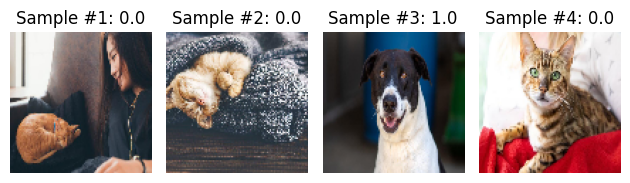

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np


# Create customized dataset
class CatsDogsDataset(Dataset):
    def __init__(self, annotations_file):
        self.imgs_info = pd.read_csv(annotations_file, header=None)

    def __len__(self):
        return len(self.imgs_info)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_path = self.imgs_info.iloc[idx, 0]
        image_raw = cv.imread(img_path)
        image_rgb = cv.cvtColor(image_raw, cv.COLOR_BGR2RGB)
        image = cv.resize(image_rgb, (100, 100))
        category = 1. if self.imgs_info.iloc[idx, 1] == 'dog' else 0.
        sample = {'image': image, 'category': category}
        return sample

# Loop training dataset
dataset_train = CatsDogsDataset(annotations_file='annotation_train.csv')
for i, sample in enumerate(dataset_train):
    image = sample['image']
    category = sample['category']
    if not i%100:
        print(i, image.shape, category)
print(i, image.shape, category)
    
dataset_test = CatsDogsDataset(annotations_file='annotation_test.csv')

# Create shuffled data loader 
dataloader_train = DataLoader(dataset_train, batch_size=1000, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=1000, shuffle=True)
samples = next(iter(dataloader_train))
fig, axs = plt.subplots(1, 4)
for i in range(4):
    image = samples['image'][i]
    category = samples['category'][i]
    axs[i] = plt.subplot(1, 4, i + 1)
    axs[i].set_title(f'Sample #{i+1}: {category}')
    axs[i].axis('off')
    axs[i].imshow(image)
    plt.tight_layout()


> You can re-run the above coding cell to get different samples. 

### 1.3 Preprocess the Data
A typical binary classification dataset is made up with a feature matrix: $\mathbf{X} = [^{(1)}\mathbf{x}, ^{(2)}\mathbf{x}, ..., ^{(M)}\mathbf{x}]^T$. and a target vector $\mathbf{y} = [^{(1)}y, ^{(2)}y, ..., ^{(M)}y]^T$. Where $M$ is the total number of instances in the dataset, $^{(m)}\mathbf{x}$ is a normalized and flattened image array, and $^{(m)}y \in \{0, 1\}$.

- A colored image is usually represented by a **3-dimensional array with shape $(width, height, 3)$**. Where, $width$ indicates number of pixel columns, $height$ indicates number of pixel rows, and 3 indicates 3 color channels (red, green , blue).
- When a digital image is loaded, each pixel bears an integer value ranged **0~255** to represent the color intensity.

![](https://miro.medium.com/v2/format:webp/1*pFywKuWmz7Xk07OXxPiX2Q.png)

We will access the raw data by extracting it from the dataloaders. Then, process and prepare the raw data so that it can be used in later steps.

### $\color{violet}{\textbf{(20\%) Exercise 1: Data Preprocessing}}$
1. Separate raw feature array and target array.
2. Reshape feature array and target array.
3. Rescale feature arrary, represent each pixel with a float numbers in range 0~1. 

In [4]:
# Extract features/images and targets/labels
data_train = next(iter(dataloader_train))
data_test = next(iter(dataloader_test))


# Separate features from targets 
raw_feature_train = data_train['image'].numpy()
raw_feature_test = data_test['image'].numpy()
raw_target_train = data_train['category'].numpy()
raw_target_test = data_test['category'].numpy()

### START CODE HERE ### (≈ 6 lines of code)
# Reshape feature matrix to (M, width*height*3), target vector to (M, 1)
reshaped_feature_train = raw_feature_train.reshape(raw_feature_train.shape[0], -1)
reshaped_feature_test = raw_feature_test.reshape(raw_feature_test.shape[0], -1)
reshaped_target_train = raw_target_train.reshape(-1 ,1)
reshaped_target_test = raw_target_train.reshape(-1, 1)

# Rescale features within range: 0~1
rescaled_feature_train = reshaped_feature_train / 255
rescaled_feature_test = reshaped_feature_test / 255
### END CODE HERE ###

# Finalize data to be used later
feature_train = rescaled_feature_train
feature_test = rescaled_feature_test
target_train = reshaped_target_train
target_test = reshaped_target_test


# Sanity check
print(feature_train.shape, feature_test.shape, target_train.shape, target_test.shape)

(557, 30000) (140, 30000) (557, 1) (557, 1)


**Expected Output**:
>
```console
(557, 30000) (140, 30000) (557, 1) (140, 1)
```

## 2. Logistic Regression Model
Apply a sigmoid function to transform the output of a linear model within range 0~1. The new model is also called **Logistic Regression Model**.

### $\color{violet}{\textbf{(5\%) Exercise 2: Logistic Regression Model}}$
1. Let the linear model: $\mathbf{Z} = \mathbf{X} \cdot \mathbf{w}^T + b$ to take feature matrix $\mathbf{X}$ as the input and output a transformed/intermediate feature matrix $\mathbf{Z}$.
2. Apply sigmoid function on $\mathbf{Z}$, so that the prediction will be: $\mathbf{\hat{y}} = \sigma(\mathbf{Z}) = 1 / (1 + e^{-\mathbf{Z}})$ 

In [5]:
### START CODE HERE ### (≈ 2 lines of code)
def sigmoid(x):
    """ Sigmoid function
    Args:
        x: independent variable, could be an arrary of any shape or a scalar.
    Returns:
        y: dependent variable, could be an arrary of any shape or a scalar.
    """
    y = 1 / (1 + np.exp(-x))
    return y

def forward(in_features, weight, bias):
    """ Logistic model function
    Args:
        in_features: feature matrix, 2d array with shape (# samples, # pixels)
        weight: a row vector with shape (1, # pixels)
        biase: a scalar
    Returns:
        predictions: model predicted values, a column vector or 2d array with shape (# samples, 1)
    """
    predictions = sigmoid(in_features @ weight.T + bias)
    return predictions
### END CODE HERE ###


# Sanity check
np.random.seed(3321)
print(forward(np.random.normal(size=(4, feature_test.shape[1])), np.random.normal(0, 0.01, (1, feature_test.shape[1])), np.random.normal(0, 0.01)))


[[0.78035352]
 [0.68058492]
 [0.60273538]
 [0.41968119]]


**Expected Output**:
>
```console
[[0.78035352]
 [0.68058492]
 [0.60273538]
 [0.41968119]]
```

## 5. Binary Cross Entropy
It is OK to use a Mean Squared Error (MSE) function to compute the model loss. It is better to use a Binary Cross Entropy (BCE) function to assess the model for a binary classification problem. 

#### $\mathcal{L}(\mathbf{\hat{y}}, \mathbf{y}) = \frac{1}{M} \Sigma [-\mathbf{y} \log \hat{\mathbf{y}} - (1 - \mathbf{y}) \log(1 - \hat{\mathbf{y}})]$
### $\color{violet}{\textbf{(5\%) Exercise 3: Cross Entropy Loss}}$


In [ ]:
### START CODE HERE ### (≈ 1 line of code)
def bce_loss(predictions, labels):
    """
    Binary Cross Entropy function
        Args:
            predictions: model predicted values, a 2d array with shape (# samples, 1)
            labels: labeled values from data set, a 2d array with shape (# samples, 1)
        Returns:
            loss_value: averaged CE error, a scalar
    """
    loss_value = np.mean(-labels * np.log(predictions) - (1 - labels) * np.log(1 - predictions))
    return loss_value
### END CODE HERE ###


# Sanity check
np.random.seed(3321)
print(bce_loss(forward(np.random.normal(size=(4, feature_test.shape[1])), np.random.normal(0, 0.01, (1, feature_test.shape[1])), np.random.normal(0, 0.01)), np.random.randint(0, 2, (4, 1))))

**Expected Output**:
>
```console
0.5250353081044535
```

## 6. Backpropagation
As there was one extra step (sigmoid activation) to compute model predictions, an extra step is needed to compute gradient of the loss.
According to the chain rule:

#### $\frac{\partial \mathcal{L}}{\partial \mathbf{w}} = \frac{1}{M} \cdot \frac{\partial \mathcal{L}}{\partial \mathbf{\hat{y}}} \cdot \frac{\partial \mathbf{\hat{y}}}{\partial \mathbf{Z}} \cdot \frac{\partial \mathbf{Z}}{\partial \mathbf{w}}$
#### $\frac{\partial \mathcal{L}}{\partial b} = \frac{1}{M} \cdot \frac{\partial \mathcal{L}}{\partial \mathbf{\hat{y}}} \cdot \frac{\partial \mathbf{\hat{y}}}{\partial \mathbf{Z}} \cdot \frac{\partial \mathbf{Z}}{\partial b}$
Where,
#### $\frac{\partial \mathcal{L}}{\partial \mathbf{\hat{y}}} = - \frac{\mathbf{y}}{\mathbf{\hat{y}}} + \frac{1 -\mathbf{y}}{1 -\mathbf{\hat{y}}}$
#### $\frac{\partial \mathbf{\hat{y}}}{\partial \mathbf{Z}} = \sigma (\mathbf{Z}) (1 - \sigma(\mathbf{z})) = \mathbf{\hat{y}} (1 - \mathbf{\hat{y}})$
#### $\frac{\partial \mathbf{Z}}{\partial \mathbf{w}} = \mathbf{X}$
#### $\frac{\partial \mathbf{Z}}{\partial b} = 1$
Thus,
#### $\frac{\partial \mathcal{L}}{\partial \mathbf{w}} = \frac{1}{M} [(- \frac{\mathbf{y}}{\mathbf{\hat{y}}} + \frac{1 -\mathbf{y}}{1 -\mathbf{\hat{y}}}) \mathbf{\hat{y}} (1 - \mathbf{\hat{y}})]^T \cdot \mathbf{X}$
#### $\frac{\partial \mathcal{L}}{\partial b} = \frac{1}{M} (- \frac{\mathbf{y}}{\mathbf{\hat{y}}} + \frac{1 -\mathbf{y}}{1 -\mathbf{\hat{y}}}) \mathbf{\hat{y}} (1 - \mathbf{\hat{y}})$

### $\color{violet}{\textbf{(40\%) Exercise 4: Gradient Descent Optimization}}$
- Define a function to compute gradient of loss
- Perform gradient descent optimization using appropriate iterations and learning rate.
    1. Initialize weights and bias
    2. Make predictions
    3. Update weights and bias
    4. Log training loss and test loss
    5. Repeat 2 to 5 until converge.



In [ ]:

### START CODE HERE ### (≈ 12 lines of code)
def grad(prediction, target, feature):
    """ Gradient function with sigmoid activation
    Args:
        prediction: model predicted value, a 2d array with shape (# samples, 1)
        target: labeled value from data set, a 2d array with shape (# samples, 1)
        feature: feature matrix, a 2d array with shape (# samples, # pixels)
    Returns:
        dL_dw: row vector of BCE loss partial derivatives w.r.t. weights, 2d array with shape (1, # features)
        dL_db: scalar of BCE loss partial derivatives w.r.t. bias
    """
    dL_dw = None
    dL_db = None
    
    return dL_dw, dL_db

# Initialize parameters
w = None
b = None
num_iters = None
learning_rate = None
losses_train, losses_test = [], []
# Optimization loop
for i in range(num_iters):
    pred_train = None
    dw, db = None
    loss_train = None
    loss_test = binary_cross_entropy_loss(forward(feature_test, w, b), target_test)
    w = None
    b = None
    print(f"Iteration {i+1} training loss: {loss_train}, test loss: {loss_test}")
    losses_train.append(loss_train)
    losses_test.append(loss_test)
### END CODE HERE ### 


plt.plot(range(num_iters), losses_train, 'b--', range(num_iters), losses_test, 'r')

## 7. Evaluation
You can treat the model output, $\mathbf{\hat{y}}$ as the probabilities of the images being classified as dog pictures. Set the classification threshold to be 0.5, we can categorize an image as a cat image ($^{(m)}y <= 0.5$) or a dog image ($^{(m)}y > 0.5$)
### $\color{violet}{\textbf{(15\%) Exercise 5: Evaluation on Test Data}}$


In [ ]:
### START CODE HERE ### (≈ 6 lines of code)
pred_test = None  # make predictions on test features
category_test = None  # Use threshold of 0.5 to assign class 0 or 1 to each individual in test dataset. You may need two lines to get the classification done

prediction_correctness = None  # Find out which predictions are correct
num_correct = None  # Calculate how many correct predictions are made
accuracy = None  # Calculate accuracy rate: correct # / total #
### END CODE HERE ###


print(accuracy)


## 8. Test
Download new images to this folder and try to use your model to classify them.

### $\color{violet}{\textbf{(15\%) Exercise 6: Test Model with New Image}}$

In [ ]:
### START CODE HERE ### (≈ 12 lines of code)
image_raw = None  # read the raw image from a file
image_rgb = None  # Convert BGR to RGB
image_resize = None  # Resize image to shape (200, 200, 3)
image_flatten = None  # Flatten image array to a row vector with shape (1, 200*200*3)
image_rescale = None  # rescale pixel value from 0~255 to 0.~1.
dog_likelihood = None  # predict new image with your model
### END CODE HERE ### 

is_dog = dog_likelihood > 0.5
if is_dog.squeeze():
    print("It's dog!") 
else:
    print("It's cat!") 


# Congratulations! You have finished this assignment!